In [144]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.over_sampling import SMOTE
import shap

df = pd.read_csv("/Users/ronakvadher/Downloads/healthcare_fraud_detection/data/simulated_nhis_healthcare_claims 1(2).csv")
print(df.shape)
print(df.columns)
df.head()

df['Fraud Type'].value_counts()

(1500, 9)
Index(['Patient ID', 'Age', 'Gender', 'Date Admitted', 'Date Discharged',
       'Diagnosis', 'Treatment', 'Amount Billed', 'Fraud Type'],
      dtype='object')


Fraud Type
No Fraud           887
Fake Treatment     243
Phantom Billing    206
Ghost Enrollee     164
Name: count, dtype: int64

In [90]:
# Create binary label
df['Is_Fraud'] = df['Fraud Type'].apply(lambda x: 0 if x == 'No Fraud' else 1)
df.drop(columns=['Fraud Type'], inplace=True)

# Drop ID-like columns
df.drop(columns=['ClaimID', 'PatientID', 'ProviderID'], inplace=True, errors='ignore')

# Fill missing values
df.fillna(method='ffill', inplace=True)

# Encode categorical columns
le = LabelEncoder()
for col in df.select_dtypes(include='object').columns:
    df[col] = le.fit_transform(df[col])

# Separate features and target
X = df.drop('Is_Fraud', axis=1)
y = df['Is_Fraud']

# Scale numeric features
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

/var/folders/8c/clystdrn2mzbhk231r2vptzc0000gn/T/ipykernel_63073/3044725378.py:9: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


In [123]:
# 3. Split dataset
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

In [125]:
# 4. Handle class imbalance using SMOTE
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
X_resampled, y_resampled = sm.fit_resample(X_train, y_train)

In [127]:
# 5. Train a model (Random Forest)
rf = RandomForestClassifier(random_state=42)
rf.fit(X_resampled, y_resampled)

RandomForestClassifier(random_state=42)

In [129]:
# 6. Predictions and Evaluation
y_pred = rf.predict(X_test)
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nROC AUC Score:", roc_auc_score(y_test, rf.predict_proba(X_test)[:, 1]))


Confusion Matrix:
 [[175   2]
 [ 34  89]]

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.99      0.91       177
           1       0.98      0.72      0.83       123

    accuracy                           0.88       300
   macro avg       0.91      0.86      0.87       300
weighted avg       0.90      0.88      0.88       300


ROC AUC Score: 0.8739607735060403


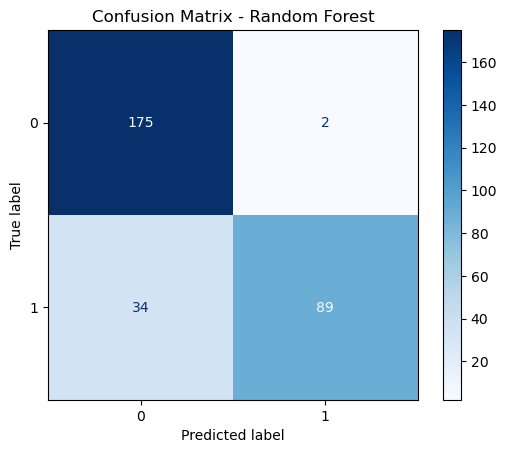

In [133]:
# Confusion Matrix plot
ConfusionMatrixDisplay.from_estimator(rf, X_test, y_test, cmap='Blues')
plt.title("Confusion Matrix - Random Forest")
plt.show()

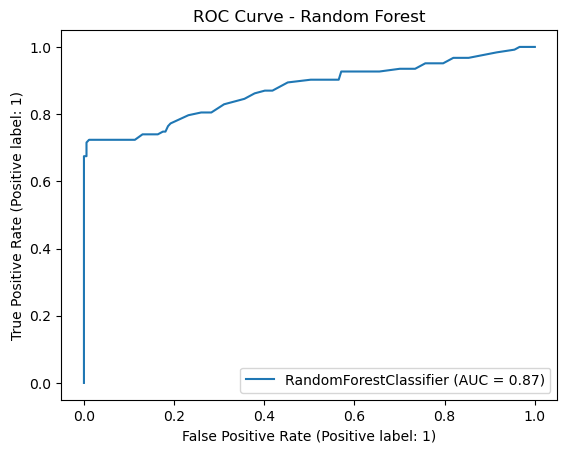

In [135]:

# ROC Curve plot
RocCurveDisplay.from_estimator(rf, X_test, y_test)
plt.title("ROC Curve - Random Forest")
plt.show()

In [141]:
from sklearn.ensemble import GradientBoostingClassifier

# Initialize models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier()
}

# Train and evaluate each model
for name, model in models.items():
    model.fit(X_resampled, y_resampled)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    
    print(f"\n=== {name} ===")
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))
    print("ROC AUC Score:", roc_auc_score(y_test, y_prob))



=== Logistic Regression ===
Confusion Matrix:
 [[127  50]
 [ 51  72]]
Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.72      0.72       177
           1       0.59      0.59      0.59       123

    accuracy                           0.66       300
   macro avg       0.65      0.65      0.65       300
weighted avg       0.66      0.66      0.66       300

ROC AUC Score: 0.7173303936429195

=== Random Forest ===
Confusion Matrix:
 [[175   2]
 [ 34  89]]
Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.99      0.91       177
           1       0.98      0.72      0.83       123

    accuracy                           0.88       300
   macro avg       0.91      0.86      0.87       300
weighted avg       0.90      0.88      0.88       300

ROC AUC Score: 0.8739607735060403

=== Gradient Boosting ===
Confusion Matrix:
 [[176   1]
 [ 34  89]]
Classification Report:
  

In [148]:
# # Explain model predictions (e.g., random forest)
# explainer = shap.Explainer(rf, X_test)
# shap_values = explainer(X_test)

# # Summary plot
# shap.summary_plot(shap_values, X_test, plot_type="bar")